In [16]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sklearn
from scipy import linalg, signal, optimize
import lockin
import phasekick2 as pk2
import phasekick as pk
import tqdm
import sigutils
import munch

def signal_average_gr(gr, ti, tf):
    b = munch.Munch()
    xs = []
    ts = []
    for ds in tqdm.tqdm(gr.values()):
        t = pk.gr2t(ds)
        m = (t > ti) & (t < tf)
        ts.append(t[m])
        x = ds['cantilever-nm'][:]
        xs.append(x[m])

    ts = np.array(ts)
    b.t = np.mean(ts, axis=0)
    x_array = np.array(xs)
    b.x = np.mean(x_array, axis=0)
    b.x = b.x - b.x.mean()
    b.t_ms = b.t * 1e3
    b.t_us = b.t * 1e6
    b.t5 = b.t[500:]
    b.x5 = b.x[500:]
    b.t5ms = b.t5*1e3
    b.t5us = b.t5*1e6
    
    b.li = lockin.LockIn(b.t, b.x, 1e6)
    b.li.lock2()
    b.li.phase(tf=0)
    
    return b

In [4]:
def make_optfunc(t0, tp, f_LP=200e3, f_HP=1e3, fs=1e6, Q=30000, ):
    b, a = signal.butter(2, np.array([f_HP, f_LP]) / (fs/2), analog=False, btype='bandpass')
    def phit(t, f_i, df_light, f_f, tau):
        t = t - t0
        tp_ = tp - t0
        return 2*np.pi*np.where(t <= 0, f_i*t,
                      np.where(t < tp_, f_i*t+ pk.phase_step(t, tau, df_light),
                              f_i*tp_+ pk.phase_step(tp_, tau, df_light) + f_f*(t-tp_)))
    
    def get_ft(f_i, df, f_f, tau):
        def ft(t):
            t = t - t0
            tp_ = tp - t0
            return np.where(t <= 0, f_i,
                      np.where(t < tp_, f_i - df_light *np.expm1(-t/tau), f_f)
                            )

    
    def xDCt(t, phaset, ft, tau, xDC0, dx_light, k_ringdown, k_light):
        t_ = t - t0
        tp_ = tp - t0
        
        delta = (ft(tp) / ft(t0))**2
        r = 1 - delta
        
        omega_tau = (2*np.pi*ft(t0)*tau)
        omega_tau2 = omega_tau**2
        omega_bar = (phaset(tp) - phaset(t0)) / (tp - t0)
        xeq = lambda t: np.where(t <= t0, xDC0, np.where(t < tp, xDC0-dx_light*np.expm1(-(t-t0)/tau),0))
        
        xresp = lambda t: np.where(t <= t0, xDC0, np.where(t < tp, ))

        return (r*(
                xDC0 + dx_light -
                dx_light * omega_tau2 / (1+omega_tau2) * np.exp(-t_/tau)
                ) + 
                delta*xDC0*np.cos(omega_bar*t) -
                dx_light * r /(1+omega_tau2) * (
                    np.cos(omega_bar * t) + omega_tau*np.sin(omega_bar * t)
                ))

    def vDCt(t, f_i, df_light, f_f, tau, xDC0, dx_light):
        t = t - t0
        tp_ = tp - t0
        delta = (f_f / f_i)**2
        r = 1 - delta
        omega_tau = (2*np.pi*f_i*tau)
        omega_tau2 = omega_tau**2
        omega_bar = 2*np.pi * (
                        phit(tp, f_i, df_light, f_f, tau) -
                         phit(t0, f_i, df_light, f_f, tau)
                        ) / (tp - t0)
        return (r*dx_light*omega_tau/(1+omega_tau2)*np.exp(-t/tau) -
                2*np.pi*delta*f_i* xDC0 * np.sin(omega_bar*t) -
                dx_light * r * omega_bar /(1+omega_tau2) * (
                    np.sin(omega_bar * t) - omega_tau*np.cos(omega_bar * t)
                ))
    
    
    def xDC_all(t, f_i, df_light, f_f, X0, Y0, tau, xDC0, dx_light):
        t_ = t - t0
        tp_ = tp - t0
        k_ringdown = 2*np.pi*f_i / Q
        
        phi = phit(t, f_i, df_light, f_f, tau)
        return np.where(t_ < 0, xDC0,
                      np.where(t_ < tp_,
                        xDCt(t, f_i, df_light, f_f, tau, xDC0, dx_light),
                        (xDCt(tp, f_i, df_light, f_f, tau, xDC0, dx_light) * np.cos(2*np.pi*f_f*(t-tp)) + 
                        vDCt(tp, f_i, df_light, f_f, tau, xDC0, dx_light) * np.sin(2*np.pi*f_f*(t-tp)) / (2*np.pi*f_f)
                         ) * np.exp(-t*k_ringdown)
                              ))
        
    def optfuncDC(t, f_i, df_light, f_f, X0, Y0, tau, Q0, Qp, xDC0, dx_light,):
        t_ = t - t0
        tp_ = tp - t0
        k_ringdown = 2*np.pi*f_i / Q
        
        phi = phit(t, f_i, df_light, f_f, tau)
        
        k_ringdown = 2*np.pi*f_i / Q0
        k_light = 2*np.pi*f_i / Qp
        Ap = np.exp(-k_light * (tp-t0))
        
        xDC = np.where(t_ < 0, xDC0,
                      np.where(t_ < tp_,
                        (xDCt(t, f_i, df_light, f_f, tau, xDC0, dx_light) - xDC0)*np.exp(-k_light*t)+xDC0,
                        (xDCt(tp, f_i, df_light, f_f, tau, xDC0, dx_light) * np.cos(2*np.pi*f_f*(t-tp)) + 
                         vDCt(tp, f_i, df_light, f_f, tau, xDC0, dx_light) * np.sin(2*np.pi*f_f*(t-tp)) / (2*np.pi*f_f)
                         ) * Ap * np.exp(-k_ringdown * (t-tp))
                              ))
        xout = ((X0 * np.cos(phi) + Y0 * np.sin(phi))*np.where(t < 0, np.exp(-t*k_ringdown),
                                                                np.where(t < tp, np.exp(-k_light*t),
                                                                        Ap * np.exp(-k_ringdown * (t-tp))))
                + xDC)
        return signal.lfilter(b, a, xout)[500:]
    
    def optfuncDC2(t, f_i, df_light, f_f, X0, Y0, tau, Q0, Qp, xDC0, dx_light, tau2, ratio):
        t_ = t - t0
        tp_ = tp - t0
        k_ringdown = 2*np.pi*f_i / Q
        df1 = ratio * df_light
        df2 = (1-ratio) * df_light
        phi = phit(t, f_i, df1, f_f, tau) + phit(t, 0.0, df2, 0.0, tau2)
        
        
        k_ringdown = 2*np.pi*f_i / Q0
        k_light = 2*np.pi*f_i / Qp
        Ap = np.exp(-k_light * (tp-t0))
        
        xDC = np.where(t_ < 0, xDC0,
                      np.where(t_ < tp_,
                        (xDCt(t, f_i, df_light, f_f, tau, xDC0, dx_light) - xDC0)*np.exp(-k_light*t)+xDC0,
                        (xDCt(tp, f_i, df_light, f_f, tau, xDC0, dx_light) * np.cos(2*np.pi*f_f*(t-tp)) + 
                         vDCt(tp, f_i, df_light, f_f, tau, xDC0, dx_light) * np.sin(2*np.pi*f_f*(t-tp)) / (2*np.pi*f_f)
                         ) * Ap * np.exp(-k_ringdown * (t-tp))
                              ))
        xout = ((X0 * np.cos(phi) + Y0 * np.sin(phi))*np.where(t < 0, np.exp(-t*k_ringdown),
                                                                np.where(t < tp, np.exp(-k_light*t),
                                                                        Ap * np.exp(-k_ringdown * (t-tp))))
                + xDC)
        return signal.lfilter(b, a, xout)[500:]

    
    def optfunc(t, f_i, df_light, f_f, X0, Y0, tau):
        t = t - t0
        k_ringdown = 2*np.pi*f_i / Q
        phi = phit(t, f_i, df_light, f_f, tau)
        return (X0 * np.cos(phi) + Y0 * np.sin(phi))*np.exp(-t*k_ringdown)
    
    def optfuncDet(t, f_i, df_light, f_f, X0, Y0, tau, Q0, Qp):
        t = t - t0
        k_ringdown = 2*np.pi*f_i / Q0
        k_light = 2*np.pi*f_i / Qp
        phi = phit(t, f_i, df_light, f_f, tau)
        Ap = np.exp(-k_light * (tp-t0))
        xout = (X0 * np.cos(phi) + Y0 * np.sin(phi))*np.where(t < 0, np.exp(-t*k_ringdown),
                                                                np.where(t < tp, np.exp(-k_light*t),
                                                                        Ap * np.exp(-k_ringdown * (t-tp))))
        return signal.lfilter(b, a, xout)[500:]
        
    
    
    def optfuncQ(t, f_i, df_light, f_f, X0, Y0, tau, Q0, Qp):
        t = t - t0
        k_ringdown = 2*np.pi*f_i / Q0
        k_light = 2*np.pi*f_i / Qp
        phi = phit(t, f_i, df_light, f_f, tau)
        Ap = np.exp(-k_light * (tp-t0))
        return (X0 * np.cos(phi) + Y0 * np.sin(phi)) * np.where(t < 0, np.exp(-t*k_ringdown),
                                                                np.where(t < tp, np.exp(-k_light*t),
                                                                        Ap * np.exp(-k_ringdown * (t-tp))))

    return phit, optfunc, optfuncQ, optfuncDC, optfuncDet, xDCt, xDC_all

In [44]:
def fit(f, xdata, ydata, p0=None, bounds=(-np.inf, np.inf), tfit=None, name=''):
    fit_data = munch.Munch()
    fit_data.popt, fit_data.pcov = optimize.curve_fit(f, xdata, ydata, p0=p0, bounds=bounds)
    fit_data.x = f(xdata, *fit_data.popt)
    fit_data.resid = ydata - fit_data.x
    if tfit is None:
        tfit = xdata
    
    fs = 1.0/np.mean(np.diff(tfit))
    li = lockin.LockIn(tfit, fit_data.x, fs)
    li.lock2()
    li.phase(tf=0)
    fit_data.li = li
    fit_data.name = name
    fit_data.li.name = name
    return fit_data

In [18]:
fs = 1e6
b, a = signal.butter(2, np.array([1e3, 200e3]) / (fs/2), analog=False, btype='bandpass')

In [19]:
phit, optfunc, optfuncQ, optfuncDC, optfuncDet, xDCt, xDC_all = make_optfunc(t0=0, tp=1.4e-3)

In [20]:
fh = h5py.File("../../data/tr-efm/151218-003450-100sun-784.h5", "r")
params =   {'fp': 4000,
             'fc': 15000,
             't_phase': -0.052,
             'ti': -54e-3,
             'tf': 6e-3,
             'Ndec': 1}
fir = lockin.lock2(66000, params['fp'], params['fc'], fs=1e6)

Response:
f   mag       dB
    0.000 1.000    0.000
 2000.000 0.982   -0.161
 4000.000 0.921   -0.715
15000.000 0.098  -20.164
30000.000 0.000 -101.125
33000.000 0.000 -110.366
66000.000 0.000 -141.187
500000.000 0.000 -196.320


In [21]:
b = signal_average_gr(fh['data'], -1.5e-3, 1.4e-3)

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.594 0.983   -0.152
 6183.187 0.927   -0.658
24732.750 0.095  -20.422
30915.937 0.011  -38.973
49465.500 0.000 -101.894
61831.875 0.000 -110.805
500000.000 0.000 -342.053


In [45]:
b.fit = fit(optfunc, b.t, b.x,
            p0=np.array([61850.0, -15.0, 62000.0, 1e-3, b.x[np.argmin(abs(b.t))], 0.0]),
            name='simp')

Response:
f   mag       dB
    0.000 1.000   -0.000
 3091.607 0.983   -0.152
 6183.215 0.927   -0.658
24732.859 0.095  -20.422
30916.073 0.011  -38.973
49465.717 0.000 -101.894
61832.146 0.000 -110.804
500000.000 0.000 -329.347


In [46]:
b.Qfit = fit(optfuncQ, b.t, b.x,
             p0=np.array([61838.0, -41.0, 62317.0, -38.0, -13.5, 0.425e-3, 30000, 15000]),
             name='Q')

Response:
f   mag       dB
    0.000 1.000   -0.000
 3091.608 0.983   -0.152
 6183.216 0.927   -0.658
24732.864 0.095  -20.422
30916.080 0.011  -38.973
49465.728 0.000 -101.894
61832.159 0.000 -110.804
500000.000 0.000 -360.356


In [47]:
b.Det = fit(optfuncDet, b.t, b.x5, p0=b.Qfit.popt, tfit=b.t5,
           name='Det.')

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.192 0.983   -0.152
 6182.384 0.927   -0.658
24729.536 0.095  -20.420
30911.920 0.011  -38.968
49459.071 0.000 -101.897
61823.839 0.000 -110.810
500000.000 0.000 -335.472


In [51]:
def plot_lis(lis, y):
    fig, ax = plt.subplots()
    for li in lis:
        ax.plot(li('t'), li(y), label=li.name)
    
    return fig, ax

In [52]:
b.dc = fit(optfuncDC, b.t, b.x5, p0=np.r_[b.Det.popt, [0.0, -1.0]],
           tfit=b.t5, name='xDC')

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.260 0.983   -0.152
 6182.520 0.927   -0.658
24730.081 0.095  -20.420
30912.601 0.011  -38.969
49460.162 0.000 -101.896
61825.202 0.000 -110.809
500000.000 0.000 -366.013


In [55]:
b.li.name='data'

In [56]:
lis = [b.Qfit.li, b.li, b.Det.li, b.dc.li]

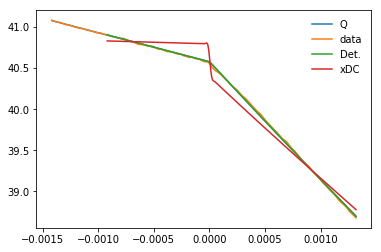

In [58]:
fig, ax = plot_lis(lis, 'A')
ax.legend()

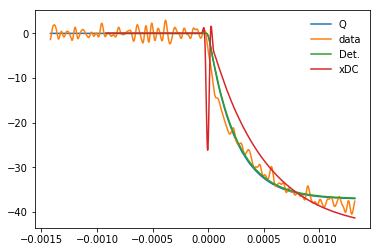

In [60]:
fig, ax = plot_lis(lis, 'df')
ax.legend()

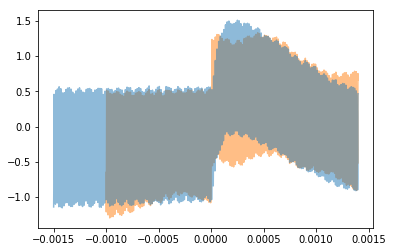

In [61]:
resids = [b.Qfit.resid, b.dc.resid]
ts = [b.t, b.t5]
i = 3
for t, resid in zip(ts, resids):
    plt.plot(t, resid, alpha=0.5, zorder=i)
    i += -1


In [62]:
xx= np.ones(100)

In [63]:
plt.plot(signal.lfilter(b, a, xx))

ValueError: object of too small depth for desired array

In [658]:
b.dc.resid

array([-0.57050302, -1.12010139, -1.10733266, ..., -0.09176547,
        0.44757533,  0.46835238])

3

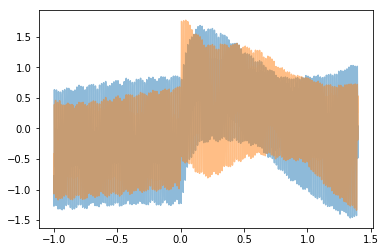

In [528]:
# plt.plot(b.t_ms[500:], b.residDet, alpha=0.7)
p0 = np.array([61854.0, -25.0, 62000.0, -37.0, -15.0, 0.25e-3, -0.5, -0.5])
p1, pcov1 = optimize.curve_fit(optfuncDC, b.t, b.x[500:], p0=p0, bounds=(bL, bH))
b.fitDC = optfuncDC(b.t, *p0)
b.fitDC1 = optfuncDC(b.t, *p1)
b.residDC = b.x[500:] - b.fitDC
b.residDC1 = b.x[500:] - b.fitDC1
# plt.plot(b.t_ms, b.resid, alpha=0.7)
plt.plot(b.t_ms[500:], b.residDet, alpha=0.5)
plt.plot(b.t_ms[500:], b.residDC1, alpha=0.5)

In [529]:
p2 = np.copy(p1)

In [530]:
p2[3:5] = 0

In [531]:
p3 = np.r_[p2[0:3], p2[5:]]

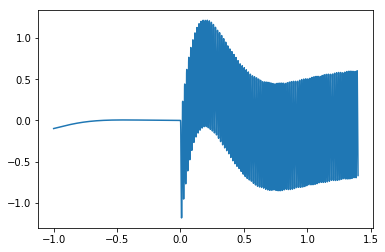

In [532]:
plt.plot(b.t_ms[500:], optfuncDC(b.t, *p2))

In [533]:
b.t

array([-0.00149949, -0.00149849, -0.00149749, ...,  0.00139751,
        0.00139851,  0.00139951])

In [537]:
print_popt(p1);

f_i =  61839.4 Hz
 df =    -44.8 Hz
f_f =  62228.9 Hz
 X0 =    -38.3 nm
 Y0 =    -13.6 nm
  τ =    496.3 µs


In [538]:
phit(0, p2[0], p2[1], p2[2], p2[5])

0.0

In [539]:
??phit

In [540]:
(phit(1.4e-3, p2[0], p2[1], p2[2], p2[5]) / 1.4e-3)

388360.79992080573

In [541]:
xDC_all(-1e-8, *p2)

array(0.6455402419495408)

In [542]:
xDC_all(1e-8, *p2)

array(0.6455353606516621)

(-0.05, 0.05)

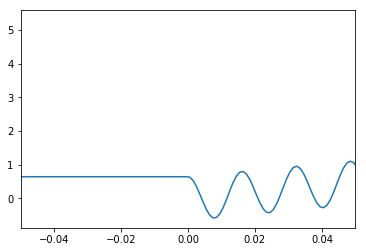

In [543]:
plt.plot(b.t_ms, xDC_all(b.t, *p2))
plt.xlim(-0.05, 0.05)

In [544]:
p2

array([  6.18394083e+04,  -4.48048944e+01,   6.22288553e+04,
         0.00000000e+00,   0.00000000e+00,   4.96309044e-04,
         6.45540242e-01,  -3.91265258e+02])

In [545]:
bL = np.zeros_like(p0) - np.inf
bH = np.zeros_like(p0) + np.inf
bL[5] = 0

In [546]:
def print_popt(x, cov=None, print_string=True):
    names = ["f_i = {:8.1f}{}Hz",
             " df = {:8.1f}{}Hz",
             "f_f = {:8.1f}{}Hz",
             " X0 = {:8.1f}{}nm",
             " Y0 = {:8.1f}{}nm",
            u"  τ = {:8.1f}{}µs",
            ]
    scales = [1, 1, 1, 1, 1, 1e6]
    string = []
    if cov is None:
        covs = [" " for i in x]
    
    for n, name, cov, scale in zip(x, names, covs, scales):
        string.append(name.format(n*scale, cov))
    string = "\n".join(string)
    if print_string:
        print(string)
    return string

In [547]:
print_popt(p1[0:6]);
print("\nDet:")
print_popt(b.poptDet[0:6]);

f_i =  61839.4 Hz
 df =    -44.8 Hz
f_f =  62228.9 Hz
 X0 =    -38.3 nm
 Y0 =    -13.6 nm
  τ =    496.3 µs

Det:
f_i =  61840.2 Hz
 df =    -37.1 Hz
f_f =  62317.0 Hz
 X0 =    -38.0 nm
 Y0 =    -13.3 nm
  τ =    247.5 µs


In [548]:
li = lockin.LockIn(b.t[500:], b.fitDC1, 1e6)
li.lock2()
li.phase(tf=0)

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.259 0.983   -0.152
 6182.518 0.927   -0.658
24730.072 0.095  -20.420
30912.590 0.011  -38.969
49460.144 0.000 -101.896
61825.180 0.000 -110.809
500000.000 0.000 -345.085


In [551]:
li2 = lockin.LockIn(b.t, b.x, 1e6)
li2.lock2()
li2.phase(tf=0)

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.594 0.983   -0.152
 6183.187 0.927   -0.658
24732.750 0.095  -20.422
30915.937 0.011  -38.973
49465.500 0.000 -101.894
61831.875 0.000 -110.805
500000.000 0.000 -342.053


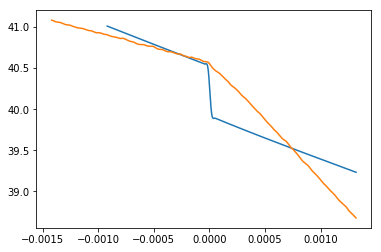

In [552]:
plt.plot(li('t'), li('A'))
plt.plot(li2('t'), li2('A'))

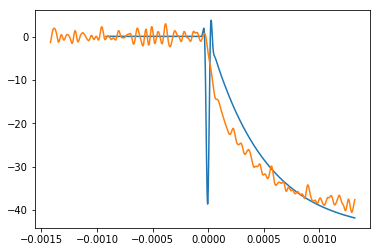

In [557]:
plt.plot(li('t'), li('df'))
plt.plot(li2('t'), li2('df'))

NameError: name 'x_DC1' is not defined

In [455]:
def offset(x):
    return x - x.mean()

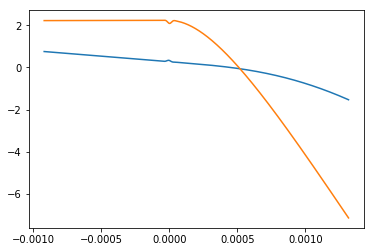

In [456]:
plt.plot(li('t'), offset(li('X')))
plt.plot(li('t'), offset(li('Y')))

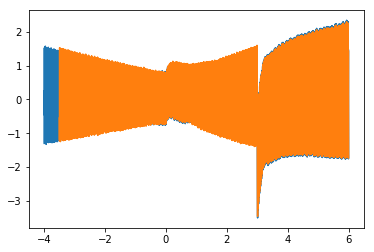

In [263]:
plt.plot(b.t_ms, b.resid)
plt.plot(b.t_ms[500:], b.residDet)

In [519]:
b.poptDC, b.pcovDC = optimize.curve_fit(optfuncDC, b.t, b.x, p0=np.r_[popt, 30000, 1.])

ValueError: operands could not be broadcast together with shapes (2400,) (2900,) 

(-100, 100)

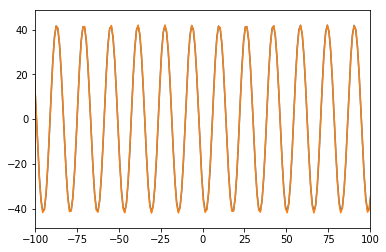

In [213]:
plt.plot(b.t_us, b.x)
plt.plot(b.t_us, b.fit)
plt.xlim(-100, 100)

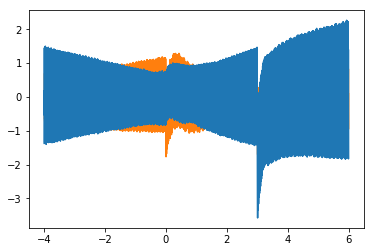

In [221]:
plt.plot(b.t_ms, b.resid)
plt.plot(b.t_ms[10:], b.residDC[10:], zorder=0)

In [222]:
b.poptDC

array([  6.18422065e+04,  -1.96898119e+01,   6.19985028e+04,
        -3.92157681e+01,  -1.38074582e+01,   3.83623749e-04,
        -7.10116491e-01,  -2.94085387e+02])

In [ ]:
b.poptDC

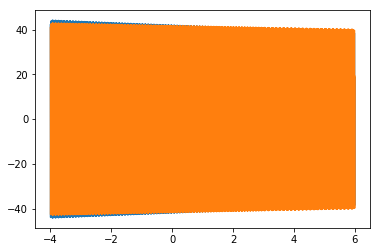

In [157]:
plt.plot(b.t_ms, b.fit)
plt.plot(b.t_ms, b.fitQ)

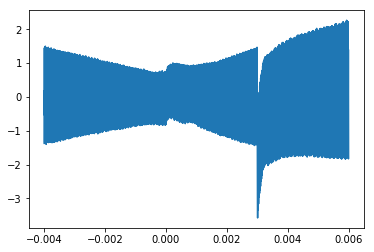

In [116]:
plt.plot(b.t, b.x - optfunc(b.t, *popt))

In [520]:
print(phit(0.00299,*popt[:-2]))
print(phit(0.00301,*popt[:-2]))

1163.3888751
1171.18002488


In [159]:
A = np.array([[0, 1], [-(0.062*2*np.pi)**2, 0]])

In [160]:
A

array([[ 0.        ,  1.        ],
       [-0.15175504,  0.        ]])

In [164]:
F = np.eye(2) - (A * 1)

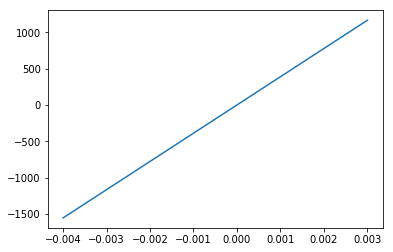

In [113]:
plt.plot(b.t[b.t < 0.003], phit(b.t, *popt[:-2])[b.t < 0.003])

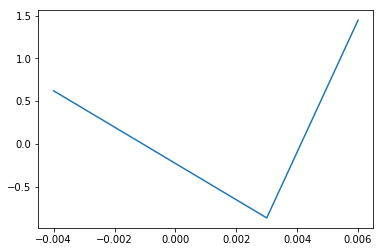

In [114]:
plt.plot(b.t, phi - phi_lin)

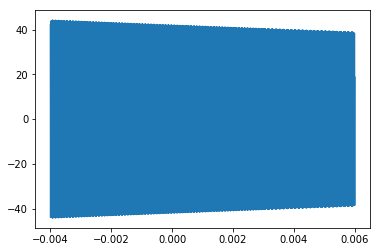

In [89]:
plt.plot(b.t, optfunc(b.t, *popt))

In [50]:
lockin.expfallt()

<function lockin.expfallt>

In [ ]:
plt.plot(lockin.expfallt(b.t, popt[]))